<a href="https://colab.research.google.com/github/yundddd/graph_generator/blob/models/GNN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
1. https://github.com/emalgorithm/directed-graph-neural-network/tree/main
2. https://emanuelerossi.co.uk/blog/2023/dirgnn/

# Import dependencies

In [1]:
pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 41.5 MB/s eta 0:00:00


In [2]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00


In [3]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
#from torch_sparse import SparseTensor
import torch.nn.functional as F
from torch.nn import ModuleList, Linear
from torch_geometric.nn import (
    SAGEConv,
    GCNConv,
    GATConv,
)
import torch
import networkx as nx
import numpy as np
import os
import os.path as osp
import pandas as pd
from torch_geometric.data import Data, Dataset, InMemoryDataset, download_url
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load PyG dataset

In [5]:
from torch_geometric.data import Data, DataLoader

In [6]:
FEATURE_DIMENSION = 9
TIMESTAMP_FEATURE_INDEX = 3
HEALTHY_NODE_LABEL = 0
ROOT_CAUSE_NODE_LABEL = 1

In [7]:
class SimulatedDataset():
  def __init__(self, edge_idx_path, node_features_path, fault_label_path):
    self.edge_idx_path = edge_idx_path
    self.node_features_path = node_features_path
    self.fault_label_path = fault_label_path

    self.edge_index = self.get_edge_index(self.edge_idx_path)
    self.node_features, self.node_labels = self.get_node_features(self.node_features_path, self.fault_label_path)
    self.dataset_stats()


  def get_edge_index(self, path):
      edges = []
      with open(path, "r") as output:
        i = 0
        for line in output:
          edge = line.strip().split(',')
          edges.append([int(edge[0]), int(edge[1])])
      return torch.tensor(edges, dtype=torch.long).t().contiguous() # put edges into COO format

  def get_node_at_fault(self, path):
    node_at_fault, timestamp_of_fault = 0, 0
    with open(fault_label_path, "r") as output:
      ind = 0
      for line in output:
        node_at_fault, timestamp_of_fault = line.strip().split(',')
        ind += 1
      assert ind == 1 # there should only be one line in this file
    return int(node_at_fault), int(timestamp_of_fault)

  def get_node_features(self, node_features_path, fault_label_path):
    node_features, node_labels = [], []
    node_at_fault, timestamp_of_fault = self.get_node_at_fault(fault_label_path)
    with open(node_features_path, "r") as output:
      for line in output:
        items = line.strip().split(',')
        features = [list(map(int, items[i + 1 : i + FEATURE_DIMENSION + 1]))
                          for i in range(0, len(items), FEATURE_DIMENSION + 1)]
        time = max([node[TIMESTAMP_FEATURE_INDEX] for node in features]) # features[node_at_fault][TIMESTAMP_FEATURE_INDEX]
        features = torch.tensor(features)
        node_features.append(features)
        labels = [HEALTHY_NODE_LABEL] * features.shape[0]
        if time >= timestamp_of_fault:
          labels[node_at_fault] = ROOT_CAUSE_NODE_LABEL
        labels = torch.tensor(labels).reshape(features.shape[0])
        node_labels.append(labels)
    return node_features, node_labels

  def dataset_stats(self):
    self.feature_dimension = self.node_features[0].shape[1]
    self.num_nodes = self.node_features[0].shape[0]
    self.num_edges = self.edge_index.shape[1]
    self.num_graphs = len(self.node_features)
    self.num_classes = 2

  def report_dataset_stats(self):
    print(f'Number of nodes: {self.num_nodes}')
    print(f'Number of edges: {self.num_edges}')
    print(f'Number of graphs: {self.num_graphs}')
    print(f'Number of classes: {self.num_classes}')
    print(f'Feature dimension: {self.feature_dimension}')
    print(f'Node features: {self.node_features}')
    print(f'Node labels: {self.node_labels}')
    print(f'Edge index: {self.edge_index}')

## Load simulated autonomous vehicle data

In [8]:
auto_vehicle_folder = '/content/drive/MyDrive/CS224 Project/autonomous_vehicle'

In [9]:
subfolders = list(os.listdir(auto_vehicle_folder))
subfolders.remove('.DS_Store')
subfolders

['crash_camera_driver1',
 'crash_tracker',
 'drop_raw_camera1_publish',
 'drop_raw_camera1_receive',
 'mutate_raw_camera1_publish']

In [10]:
def get_injection_time(file_name):
  return file_name.split('_')[-1].split('.')[0]

In [32]:
raw_data_path = {}
for subfolder in subfolders:
  subfolder_path = os.path.join(auto_vehicle_folder, subfolder)
  raw_data_path[subfolder] = {}

  for file_name in os.listdir(subfolder_path):
    if 'inject' in file_name:
      injection_time = get_injection_time(file_name)
      node_features_path = os.path.join(subfolder_path, f'node_feature_inject_at_{injection_time}.csv')
      fault_label_path = os.path.join(subfolder_path, f'fault_label_inject_at_{injection_time}.csv')
      edge_idx_path = os.path.join(subfolder_path, 'edge_index.csv')
      raw_data_path[subfolder][injection_time] = {}
      raw_data_path[subfolder][injection_time]['node_features_path'] = node_features_path
      raw_data_path[subfolder][injection_time]['fault_label_path'] = fault_label_path
      raw_data_path[subfolder][injection_time]['edge_idx_path'] = edge_idx_path

In [21]:
sum([len(raw_data_path[subfolders[i]]) for i in range(len(subfolders))])

200

In [22]:
subfolders

['crash_camera_driver1',
 'crash_tracker',
 'drop_raw_camera1_publish',
 'drop_raw_camera1_receive',
 'mutate_raw_camera1_publish']

In [33]:
instance = raw_data_path[subfolders[0]]['1100']

In [34]:
instance

{'node_features_path': '/content/drive/MyDrive/CS224 Project/autonomous_vehicle/crash_camera_driver1/node_feature_inject_at_1100.csv',
 'fault_label_path': '/content/drive/MyDrive/CS224 Project/autonomous_vehicle/crash_camera_driver1/fault_label_inject_at_1100.csv',
 'edge_idx_path': '/content/drive/MyDrive/CS224 Project/autonomous_vehicle/crash_camera_driver1/edge_index.csv'}

In [35]:
instance = raw_data_path[subfolders[0]]['1100']
pyg_dataset = SimulatedDataset(instance['edge_idx_path'], instance['node_features_path'], instance['fault_label_path'])

In [36]:
data_list = []
for i in range(pyg_dataset.num_graphs):
    x = pyg_dataset.node_features[i]
    y = pyg_dataset.node_labels[i]
    edge_index = pyg_dataset.edge_index

    graph_data = Data(x=x, y=y, edge_index=edge_index)
    data_list.append(graph_data)

In [37]:
data_list

[Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41], y=[29]),
 Data(x=[29, 9], edge_index=[2, 41

In [38]:
loader = DataLoader(data_list, batch_size=pyg_dataset.num_nodes, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#Build models

In [39]:
class DirectedGCN(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes):
        super(DirectedGCN, self).__init__()
        self.conv1 = GCNConv(input_features, hidden_dim, improved=True)  #improved option for directed graphs
        self.conv2 = GCNConv(hidden_dim, output_classes, improved=True)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [40]:
class DirectedGraphSAGE(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes):
        super(DirectedGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_features, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [41]:
class DirectedGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, heads=18):
        super(DirectedGAT, self).__init__()
        self.conv1 = GATConv(input_features, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, output_classes, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


#Train and evaluate models

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns

In [43]:
pyg_dataset.num_graphs

9141

In [44]:
input_features = pyg_dataset.feature_dimension
hidden_dim = input_features * 2
output_classes = pyg_dataset.num_classes

In [45]:
MODELS = {
    'DirectedGCN': DirectedGCN,
    'DirectedGraphSAGE': DirectedGraphSAGE,
    'DirectedGAT': DirectedGAT,
    #'GRNN': GRNN
}

In [46]:
def apply_model(model_name, input_features, hidden_dim, output_classes):
    model = MODELS[model_name](input_features, hidden_dim, output_classes)
    return model, model_name

In [47]:
def train(model, loader, num_epoch, verbose, lr=0.01, weight_decay=5e-4, loss_function=F.nll_loss):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Define optimizer once
    for epoch in range(num_epoch):
        for data in loader:
            optimizer.zero_grad()
            #forward
            data.x = data.x.float()
            out = model(data)  #output = [85,2] <- [17, 5] graphs 2 classes of labels

            #node-level labels loss
            loss = loss_function(out, data.y)  #data.y = [85,]

            #backpropagration
            loss.backward()
            optimizer.step()
        if verbose:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


In [48]:
def evaluate(model, model_name, loader, plt_confusion_matrix = True):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():  # Disable gradient tracking
        for data in loader:
            data.x = data.x.float()  # Ensure features are in float format
            out = model(data)  # Forward pass
            pred = out.argmax(dim=1)  # Get predictions
            preds.append(pred.cpu())  # Store predictions on CPU
            targets.append(data.y.cpu())  # Store true labels on CPU

    preds = torch.cat(preds)
    targets = torch.cat(targets)

    report = classification_report(targets, preds, digits=4, zero_division=0)
    print(f'Model: {model_name}')
    print(report)

    if plt_confusion_matrix:
      generate_cm(targets, preds, model_name)

In [49]:
def generate_cm(y_true, y_pred, model_name):
  cm = confusion_matrix(y_true, y_pred)

  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'{model_name} Confusion Matrix')
  plt.show()

# Compare models

**Precision**: Measures the accuracy of positive predictions.

**Recall**: Measures the model’s ability to find all relevant instances of each class.

**F1-Score**: The harmonic mean of precision and recall, which balances the two metrics.

**Support**: The number of true instances for each class.

**Macro Average**: Takes the average of each metric without considering the class support, providing an unweighted view.

**Weighted Average**: Takes the average of each metric, weighted by the number of instances in each class.

Model: DirectedGCN
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    263010
           1     0.0000    0.0000    0.0000      2079

    accuracy                         0.9922    265089
   macro avg     0.4961    0.5000    0.4980    265089
weighted avg     0.9844    0.9922    0.9883    265089



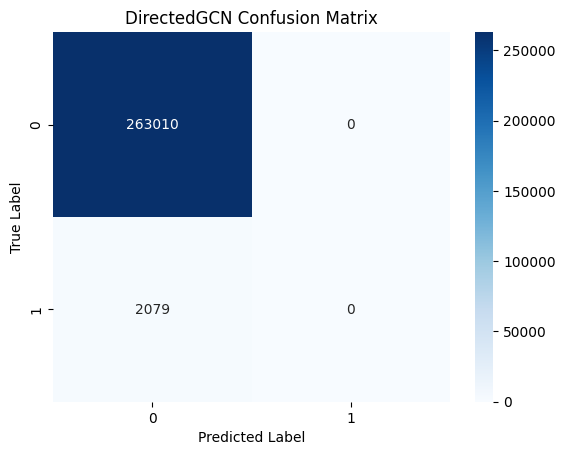

In [50]:
model1, model_name1 = apply_model(list(MODELS.keys())[0], input_features, hidden_dim, output_classes)
train(model1, loader, 1, verbose=False)
evaluate(model1, model_name1, loader)

In [52]:
model1

DirectedGCN(
  (conv1): GCNConv(9, 18)
  (conv2): GCNConv(18, 2)
  (dropout): Dropout(p=0.5, inplace=False)
)

Model: DirectedGraphSAGE
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    263010
           1     0.0000    0.0000    0.0000      2079

    accuracy                         0.9922    265089
   macro avg     0.4961    0.5000    0.4980    265089
weighted avg     0.9844    0.9922    0.9883    265089



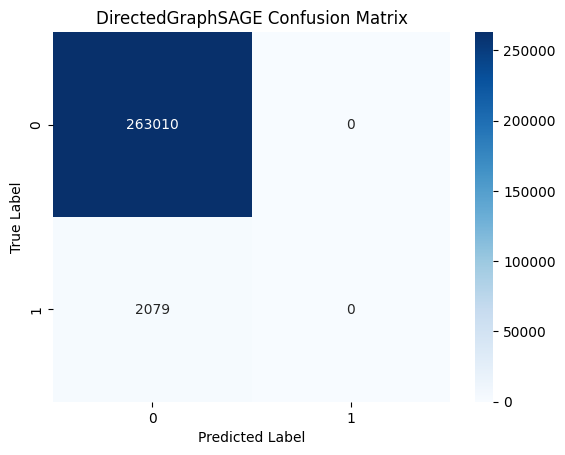

In [53]:
model2, model_name2 = apply_model(list(MODELS.keys())[1], input_features, hidden_dim, output_classes)
train(model2, loader, 1, verbose=False)
evaluate(model2, model_name2, loader)

In [54]:
model2

DirectedGraphSAGE(
  (conv1): SAGEConv(9, 18, aggr=mean)
  (conv2): SAGEConv(18, 2, aggr=mean)
  (dropout): Dropout(p=0.5, inplace=False)
)

Model: DirectedGAT
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    263010
           1     0.0000    0.0000    0.0000      2079

    accuracy                         0.9922    265089
   macro avg     0.4961    0.5000    0.4980    265089
weighted avg     0.9844    0.9922    0.9883    265089



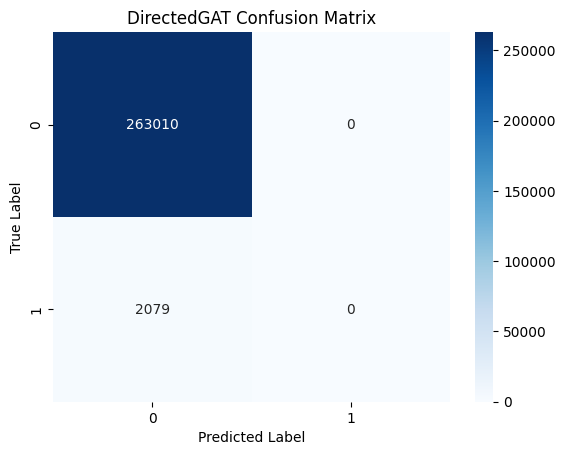

In [55]:
model3, model_name3 = apply_model(list(MODELS.keys())[2], input_features, hidden_dim, output_classes)
train(model3, loader, 1, verbose=False)
evaluate(model3, model_name3, loader)

In [56]:
model3

DirectedGAT(
  (conv1): GATConv(9, 18, heads=18)
  (conv2): GATConv(324, 2, heads=1)
  (dropout): Dropout(p=0.5, inplace=False)
)